In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from matplotlib import pyplot as plt

from models.cir import CoxIngersollRossModel

warnings.simplefilter('ignore', FutureWarning)

In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
df = pd.read_csv('./data_processing/data/fed-funds-rate-historical-chart.csv', parse_dates=[0])
df.columns = ['date', 'value']
df.head()

,date,value
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88


In [12]:
monthly_rate = df.groupby(
    df['date'].dt.strftime('%Y-%m-1')
)['value'].apply(lambda group: list(group)[0]).reset_index()
monthly_rate['date'] = pd.to_datetime(monthly_rate['date'])
monthly_rate.head()

,date,value
0,1954-07-01,1.13
1,1954-08-01,0.25
2,1954-09-01,1.44
3,1954-10-01,0.50
4,1954-11-01,1.38


In [16]:
monthly_rate = monthly_rate[(monthly_rate['date'].dt.year >= 2013) & (monthly_rate['date'].dt.month >= 9)]

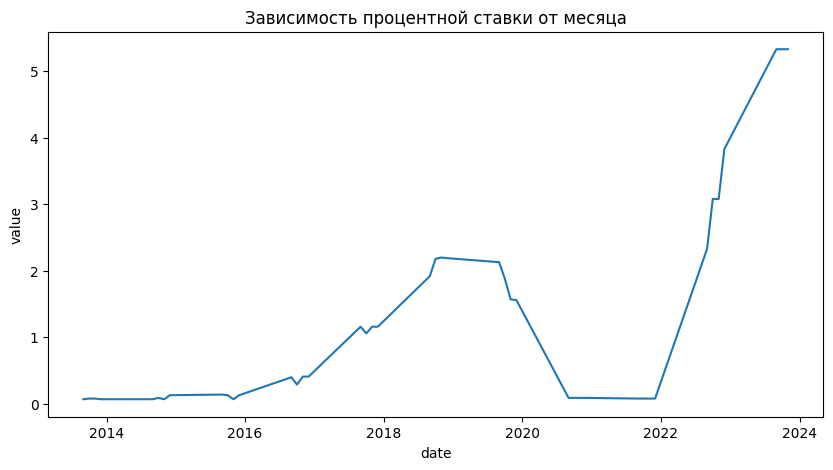

In [17]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate, x='date', y='value')
plt.title('Зависимость процентной ставки от месяца');

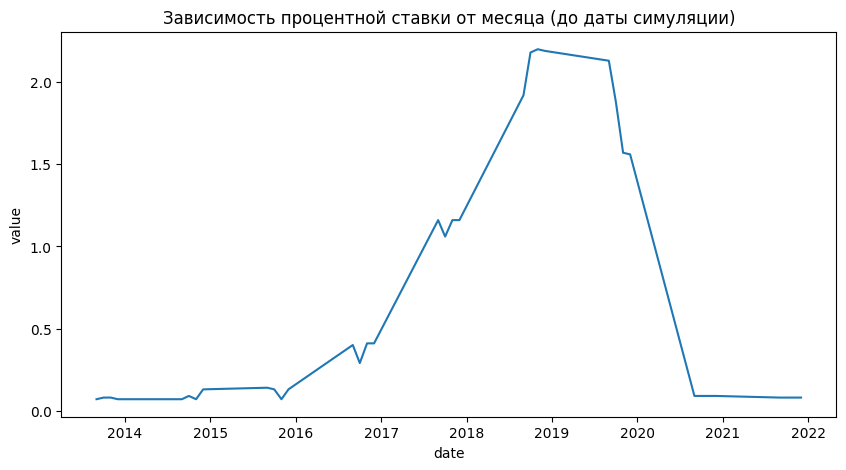

In [19]:
simulation_date = datetime.datetime(2021, 12, 10)
monthly_rate = monthly_rate[monthly_rate['date'] < simulation_date]
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate, x='date', y='value')
plt.title('Зависимость процентной ставки от месяца (до даты симуляции)');

In [20]:
cir = CoxIngersollRossModel()
cir.estimate_ols(monthly_rate['value'])
print(cir)

CIR(a=0.03820445827474804, b=0.6763357016070028, sigma=0.34030519063341663)


In [22]:
r_start = 0.07
N = 100
T = 24
simulated_rate, expected_value, expected_error = cir.make_interest_rate_simulations(r_start, N, T)
print("The expected value for the interest rate is:", "{}".format(expected_value))
print("The standard error of sample mean is:", "{}".format(expected_error))

The expected value for the interest rate is: 0.3669212830548822
The standard error of sample mean is: 0.06396486310337754


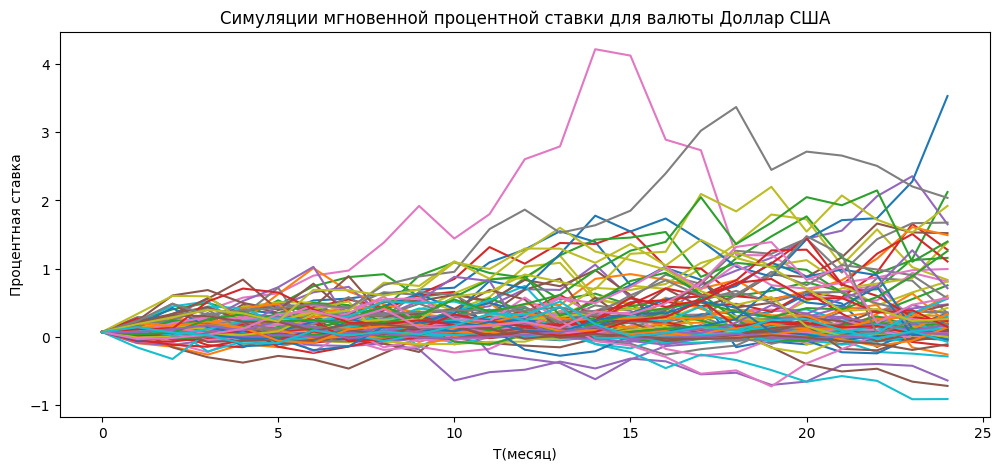

In [24]:
plt.figure(figsize=(12, 5))

for simulation in simulated_rate:
    plt.plot(np.arange(0, T + 1, 1), simulation)
plt.title('Симуляции мгновенной процентной ставки для валюты Доллар США')
plt.xlabel('T(месяц)')
plt.ylabel('Процентная ставка');